In [2]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 5.2 MB/s 
     |████████████████████████████████| 100 kB 10.3 MB/s 


DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term



Compiling model...
Building feed-forward neural network...
'build' took 0.113340 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.727260 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.34e-01, 1.49e-03, 8.01e-01]    [4.94e-01, 1.49e-03, 8.01e-01]    []  
1000      [3.49e-03, 6.99e-04, 1.19e-02]    [3.21e-03, 6.99e-04, 1.19e-02]    []  
2000      [1.79e-04, 1.05e-07, 1.19e-04]    [1.71e-04, 1.05e-07, 1.19e-04]    []  
3000      [3.08e-05, 7.84e-07, 5.84e-05]    [3.47e-05, 7.84e-07, 5.84e-05]    []  
4000      [2.67e-05, 4.96e-07, 3.36e-05]    [2.99e-05, 4.96e-07, 3.36e-05]    []  
5000      [2.30e-05, 1.97e-07, 1.53e-05]    [2.56e-05, 1.97e-07, 1.53e-05]    []  
6000      [1.91e-05, 1.03e-07, 5.23e-06]    [2.09e-05, 1.03e-07, 5.23e-06]    []  
7000      [1.52e-05, 1.80e-07, 1.73e-06]    [1.63e-05, 1.80e-07, 1.73e-06]    []  
8000      [1.24e-05, 6.24e-07, 1.15e-06]    [1.31e-05, 6.24e-07, 1.15e-06]    []  
9000      [1.04e-05, 2.11e-08, 9.46e-07]    [1.10e-05, 2.11e-08, 9.46e-07]    []  
10000   

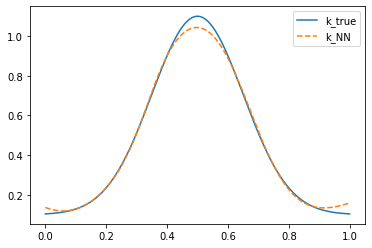

l2 relative error for u: 0.0010953008072022217


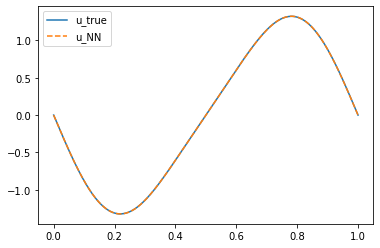

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch
Implementation for the diffusion-reaction system with a space-dependent reaction rate in paper https://arxiv.org/abs/2111.02801.
"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

l = 0.01


def k(x):
    return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15**2)


def fun(x, y):
    return np.vstack((y[1], (k(x) * y[0] + np.sin(2 * np.pi * x)) / l))


def bc(ya, yb):
    return np.array([ya[0], yb[0]])


num = 100
xvals = np.linspace(0, 1, num)
y = np.zeros((2, xvals.size))
res = solve_bvp(fun, bc, xvals, y)


def gen_traindata(num):
    return np.reshape(xvals, (-1, 1)), np.reshape(res.sol(xvals)[0], (-1, 1))


geom = dde.geometry.Interval(0, 1)


def pde(x, y):
    u, k = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    return l * du_xx - u * k - dde.backend.sin(2 * np.pi * x)


def func(x):
    return 0


ob_x, ob_u = gen_traindata(num)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary, component=0)

data = dde.data.PDE(
    geom,
    pde,
    bcs=[bc, observe_u],
    num_domain=50,
    num_boundary=8,
    train_distribution="uniform",
    num_test=1000,
)

net = dde.nn.PFNN([1, [20, 20], [20, 20], 2], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

losshistory, train_state = model.train(iterations=20000)

x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, khat = yhat[:, 0:1], yhat[:, 1:2]

ktrue = k(x)
print("l2 relative error for k: " + str(dde.metrics.l2_relative_error(khat, ktrue)))

plt.figure()
plt.plot(x, ktrue, "-", label="k_true")
plt.plot(x, khat, "--", label="k_NN")
plt.legend()
plt.show()

utrue = res.sol(x)[0]
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(uhat, utrue)))

plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()
plt.show()

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch
Implementation for the diffusion-reaction system with a space-dependent reaction rate in paper https://arxiv.org/abs/2111.02801.
"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

l = 0.01


def k(x):
    return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15**2)


def fun(x, y):
    return np.vstack((y[1], (k(x) * y[0] + np.sin(2 * np.pi * x)) / l))


def bc(ya, yb):
    return np.array([ya[0], yb[0]])


num = 100
xvals = np.linspace(0, 1, num)
y = np.zeros((2, xvals.size))
res = solve_bvp(fun, bc, xvals, y)


def gen_traindata(num):
    return np.reshape(xvals, (-1, 1)), np.reshape(res.sol(xvals)[0], (-1, 1))


geom = dde.geometry.Interval(0, 1)


def pde(x, y):
    u, k = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    return l * du_xx - u * k - dde.backend.sin(2 * np.pi * x)


def func(x):
    return 0


ob_x, ob_u = gen_traindata(num)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary, component=0)

data = dde.data.PDE(
    geom,
    pde,
    bcs=[bc, observe_u],
    num_domain=50,
    num_boundary=8,
    train_distribution="uniform",
    num_test=1000,
)

net = dde.nn.PFNN([1, [20, 20], [20, 20], 2], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

losshistory, train_state = model.train(iterations=20000)

x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, khat = yhat[:, 0:1], yhat[:, 1:2]

ktrue = k(x)
print("l2 relative error for k: " + str(dde.metrics.l2_relative_error(khat, ktrue)))

plt.figure()
plt.plot(x, ktrue, "-", label="k_true")
plt.plot(x, khat, "--", label="k_NN")
plt.legend()
plt.show()

utrue = res.sol(x)[0]
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(uhat, utrue)))

plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()
plt.show()